In [1]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [19]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from scipy.stats import t
print(torch.cuda.device_count())
print(os.getcwd())
import statsmodels
from new_dataloading_Copy1 import meanTr, stdTrtrue

1
/home/VM-Nicolas-Lafon/Danube/Update


In [20]:
ncfile = Dataset('Test_set/test2.nc')
#ncfile_noKL = Dataset('lightning_logs/version_2/test.nc')
#ncfile = Dataset('ResDanube4DVar/-exp2/model_Debit-epoch=06-val_loss=0.24-v1_res.nc')
flagprocess=4 #random maxk
print(ncfile)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): Stations(31), time(874), day(12), S(31), D(12)
    variables(dimensions): int64 stations(Stations), <class 'str'> Time(time), int64 Day(day), float64 debit_gt(time, Stations, day), float64 debit_obs(time, Stations, day), float64 debit_rec(time, Stations, day), float64 Cov_rec(time, Stations, day), int64 S(S), int64 time(time), int64 D(D)
    groups: 


In [6]:
debit_gt = ncfile['debit_gt']
debit_obs = ncfile['debit_obs']
debit_rec = ncfile['debit_rec']
debit_cov = ncfile['Cov_rec']
#debit_rec_noKL = ncfile_noKL['debit_rec']
print(debit_cov.shape)
print(debit_cov[0:50,:,9:])
print(meanTr)
print(stdTrtrue)

(874, 31, 12)
[[[-2.11020775 -2.19432698 -2.19609407]
  [-1.82741876 -1.98409253 -1.98042951]
  [-1.60824013 -1.75117508 -1.75655199]
  ...
  [-0.9378344  -1.05773766 -1.05760816]
  [-1.34828721 -1.52140756 -1.45929679]
  [-1.48314554 -1.54047195 -1.50057522]]

 [[-2.11128638 -2.19358075 -2.19625548]
  [-1.83328928 -1.98023952 -1.97967247]
  [-1.61323646 -1.74983958 -1.75461984]
  ...
  [-0.9293575  -1.05011994 -1.05313442]
  [-1.34295571 -1.52159354 -1.45518877]
  [-1.47963578 -1.54223879 -1.50109852]]

 [[-2.11248008 -2.19172244 -2.19471393]
  [-1.83600162 -1.97764978 -1.97710584]
  [-1.61595586 -1.74900625 -1.75233236]
  ...
  [-0.92915953 -1.06218244 -1.06004377]
  [-1.34299346 -1.52484269 -1.4598984 ]
  [-1.4819085  -1.53954504 -1.50163238]]

 ...

 [[-2.23150122 -2.28439977 -2.26190117]
  [-2.02194412 -2.09571212 -2.07073911]
  [-1.79111615 -1.88357263 -1.85448054]
  ...
  [-0.97105757 -1.17278408 -1.08711362]
  [-1.3662244  -1.52772544 -1.48301136]
  [-1.48827478 -1.53195369 -1.

# Reconstruction


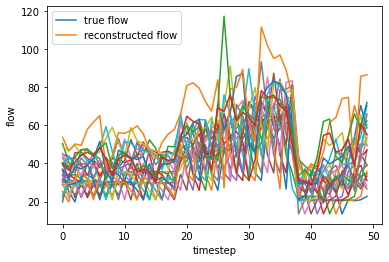

In [7]:
station = 21
plt.figure(0)
plt.plot(debit_gt[0:50,station])
plt.plot(debit_rec[0:50,station])
plt.xlabel('timestep')
plt.ylabel('flow')
plt.legend(['true flow', 'reconstructed flow'])

if flagprocess ==3 : 
    print(np.sum(debit_obs[0,:]==0))
    L1=[]
    L2=[]
    for i in range(506):
        if debit_obs[i,station]==0:
            L1.append(i)
        else : 
            L2.append(i)
    plt.figure(1)
    D=debit_gt[:,station]
    Drec=debit_rec[:,station]
    print(D[L1])
    plt.plot(D[L1])
    plt.plot(Drec[L1])
    plt.xlabel('timestep')
    plt.ylabel('flow')
    plt.legend(['true flow', 'reconstructed flow'])
    plt.figure(2)
    plt.plot(debit_gt[L2,station])
    plt.plot(debit_rec[L2,station])
    plt.xlabel('timestep')
    plt.ylabel('flow')
    plt.legend(['true flow', 'reconstructed flow'])

0.3377296018463616
21.144141638118935
[ 82.1  93.2  96.  107.  109.  115.  121.  125.  125. ]
[ 44  44  44 ... 494 494 494]
0.2323253976365733
35.245541599355136
77.63642951251647


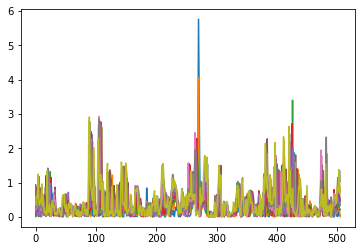

In [18]:
plt.plot(abs(debit_gt[:,station]-debit_rec[:,station])/debit_gt[:,station])
print(np.mean(abs(debit_gt[:,station]-debit_rec[:,station])/debit_gt[:,station]))
print(np.mean(abs(debit_gt[:,station]-debit_rec[:,station])))
debtrue = debit_gt[:,station]
debtrue.sort()
seuil = debtrue[455]
print(seuil)
ind= np.where(debit_gt[:,station]>seuil)
print(ind[0])
print(np.mean(abs(debit_gt[ind[0],station]-debit_rec[ind[0],station])/debit_gt[ind[0],station]))
print(np.mean(abs(debit_gt[ind[0],station]-debit_rec[ind[0],station])))
print(np.mean(debit_gt[:,station]))

In [6]:
index_sort_gt = np.argsort(debit_gt[:,station])
plt.scatter(debit_gt[index_sort_gt[450:506],station],debit_rec[index_sort_gt[450:506],station])
plt.plot(debit_gt[index_sort_gt[450:506],station],debit_gt[index_sort_gt[450:506],station])
plt.figure()
plt.scatter(debit_gt[index_sort_gt,station],debit_rec[index_sort_gt,station])
plt.plot(debit_gt[index_sort_gt,station],debit_gt[index_sort_gt,station])

IndexError: Index cannot be multidimensional

In [7]:
# Critère non-paramétrique de KL pour les extrêmes

Nn_gt = np.sum(debit_gt[:,station]>seuil)
print(Nn_gt)

Nn_rec = np.sum(debit_rec[:,station]>seuil)
print(Nn_rec)

def G_thilde(u,Y):
    l=len(Y)
    return (1-np.sum(Y<=u)/(l+1))

print(G_thilde(seuil,debit_gt[:,station]))

def L_hat(u,Y,X):
    Nn = np.sum(X>u)
    res=0
    for k in X:
        res+=(1/Nn)*np.log(G_thilde(max(k,u),Y)/G_thilde(u,Y))
        
    return(1+res)
                         
print(L_hat(seuil,debit_rec[:,station],debit_gt[:,station]))
print(L_hat(seuil,debit_gt[:,station],debit_rec[:,station]))

def K_hat(u,Y,X):
    return(-L_hat(u,Y,X)-L_hat(u,X,Y))

1049
959
-5.913214990138067


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [58]:
ncfile2 = Dataset('Dataset_danube.nc',"r")

NbDays          = 18244

In [8]:
L=[]
for i in range(31):
    L.append(ncfile2['S'+str(i+1)][:].reshape(18244,1))
        
dataset = np.concatenate((L[0],L[1],L[2],L[3],L[4],L[5],L[6],L[7],L[8],L[9],L[10],L[11],L[12],L[13],L[14],L[15],L[16],L[17],L[18],L[19],L[20],L[21],L[22],L[23],L[24],L[25],L[26],L[27],L[28],L[29],L[30]),axis=1)

# Definiton of training, validation and test dataset    
i=0
Indtrain=[]
Indval=[]
Indtest=[]
while (i+1)*395<(NbDays-1):
    x=395*i
    Indtrain.append([x,(x+305)])
    Indval.append([(x+319),(x+350)])
    Indtest.append([x+364,x+395])
    i+=1
    


NameError: name 'ncfile2' is not defined

In [49]:
print(Indtrain)
D=dataset[Indtrain[0][0]:Indtrain[0][1],3]
print(D)
for k in Indtrain[1::]:
    D=np.concatenate((D,dataset[k[0]:k[1],3]),axis=0)
print(len(D))

r=0.1
D.sort()
print(D[:10])
seuil=D[int((1-r)*len(D))]
print(seuil)

[[0, 305], [395, 700], [790, 1095], [1185, 1490], [1580, 1885], [1975, 2280], [2370, 2675], [2765, 3070], [3160, 3465], [3555, 3860], [3950, 4255], [4345, 4650], [4740, 5045], [5135, 5440], [5530, 5835], [5925, 6230], [6320, 6625], [6715, 7020], [7110, 7415], [7505, 7810], [7900, 8205], [8295, 8600], [8690, 8995], [9085, 9390], [9480, 9785], [9875, 10180], [10270, 10575], [10665, 10970], [11060, 11365], [11455, 11760], [11850, 12155], [12245, 12550], [12640, 12945], [13035, 13340], [13430, 13735], [13825, 14130], [14220, 14525], [14615, 14920], [15010, 15315], [15405, 15710], [15800, 16105], [16195, 16500], [16590, 16895], [16985, 17290], [17380, 17685], [17775, 18080]]
[419. 385. 366. 352. 419. 437. 400. 406. 417. 402. 324. 294. 280. 265.
 245. 242. 240. 238. 245. 260. 264. 264. 285. 313. 276. 267. 301. 305.
 316. 342. 360. 330. 309. 292. 289. 289. 285. 271. 235. 219. 242. 255.
 240. 243. 253. 227. 225. 228. 233. 248. 264. 299. 289. 298. 307. 342.
 391. 531. 702. 743. 735. 705. 718. 7

In [35]:
X1=np.random.randn(500)
print(max(X1))
Y1=np.random.randn(500)
print(max(Y1))
print(np.sum(X1>1))
print(np.sum(Y1>1))
print(G_thilde(3,Y1))
print(L_hat(3,X1,Y1))
print(L_hat(3,Y1,X1))
print(K_hat(3,X1,Y1))

4.477390750750359
3.0822163450876143
76
82
0.005988023952095856
1.0
-0.09861228866809113
-0.9013877113319089


In [54]:
#Risque Juliette

epsilon =0.5
g =(debit_rec[:,station]>seuil)
H = (debit_gt[:,station]>seuil)
g_eps = (debit_rec[:,station]>epsilon*seuil)
H_eps = (debit_gt[:,station]>epsilon*seuil)

compt1 = np.sum((g ^ H) &H_eps &g_eps)
print(compt1)
compt2 = np.sum((g | H) &H_eps &g_eps)
print(compt2)
R_juliette = compt1/compt2
print(R_juliette)

7
54
0.12962962962962962


# Prevision

### Premiers résultats

(874, 31, 12)
[0.68254054 0.6958673  0.7034374  0.7626443  0.8000269  0.816906
 0.8174264  0.8272233  0.85648876 0.8735844  0.8791082  0.889274
 0.8902636  0.8989246  0.9036536  0.91599566 0.9162358  0.92186815
 0.9310415  0.9340472  0.9441249  0.95390534 0.96204877 0.9625467
 0.9668326  0.973097   0.97662795 0.97916627 0.98072445 0.9905153
 0.99986875 1.0161761  1.0211504  1.022326   1.0269709  1.0336246
 1.0391368  1.0459255  1.0463736  1.0607803  1.0695109  1.079682
 1.0813348  1.0825696  1.0834796  1.0864102  1.0956652  1.0962644
 1.1010048  1.1014153 ]


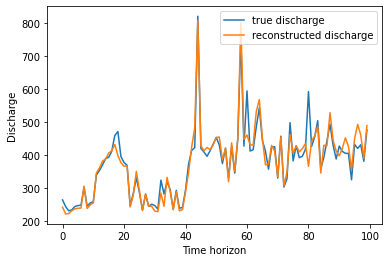

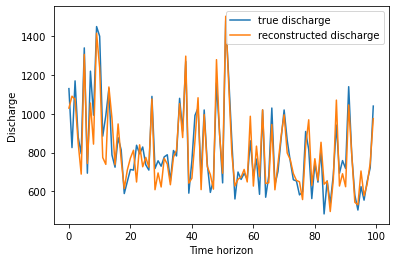

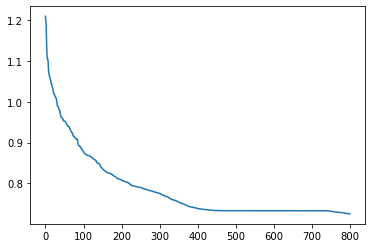

In [120]:
station = 2
Day = 9
print(debit_gt[:].shape)
index= np.argsort(debit_cov[:,station,Day])
print(debit_cov[index[:50],station,Day])

# Comparaison GT et rec pour un élément donné du test
plt.plot(debit_gt[index[700:800],station,Day])
plt.plot(debit_rec[index[700:800],station,Day])
plt.xlabel('Time horizon')
plt.ylabel('Discharge')
plt.legend(['true discharge', 'reconstructed discharge'])
plt.figure()
plt.plot(debit_gt[index[0:100],station,Day])
plt.plot(debit_rec[index[0:100],station,Day])
plt.xlabel('Time horizon')
plt.ylabel('Discharge')
plt.legend(['true discharge', 'reconstructed discharge'])
plt.figure()
plt.plot(np.sqrt(1/debit_cov[index[0:800],station,Day]))

## Courbe enveloppe

Text(0, 0.5, 'Discharge')

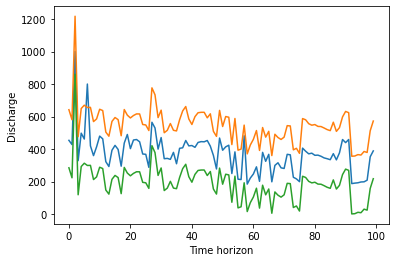

In [121]:
env_sup = debit_rec[:,station,Day]+np.sqrt(1/debit_cov[:,station,Day])*stdTrtrue[station]
env_inf = debit_rec[:,station,Day]-np.sqrt(1/debit_cov[:,station,Day])*stdTrtrue[station]

plt.plot(debit_gt[index[400:500],station,Day])
plt.plot(env_sup[index[400:500]])
plt.plot(env_inf[index[400:500]])
plt.xlabel('Time horizon')
plt.ylabel('Discharge')

## Résultats numérique

In [103]:
station = 24
#Biais dans la prédiction :
L_abs =np.sum(debit_gt[:,station,9]-debit_rec[:,station,10])/(np.mean(debit_gt[:,station,10]))
L_abs= L_abs/(506)
print(np.abs(L_abs))


0.02842063452925528


In [104]:
#Erreur relative en fonction du jour par station
D=abs(debit_gt[:,:,:]-debit_rec[:,:,:])/debit_gt[:,:,:]
print(D.shape)
# Erreur relative moyenne en fonction du jour et de la station
M = np.mean(D,0)
print(M[0,:])
#Erreur relative moyenne en fonction du jour
M2 =np.mean(M,0)
print(M2)



(874, 31, 12)
[0.07477561691274864 0.018668202200805586 0.02299695970912687
 0.020008040901201108 0.014877935953696058 0.01406140906782477
 0.012300176586493955 0.011163510258549994 0.016941834321040773
 0.0647709169430868 0.10326006860939493 0.13573030830218275]
[0.062339505341904 0.03532073863866945 0.03464165392271223
 0.03391260010931777 0.03180715111895721 0.03100284153900615
 0.028324188691626586 0.03163613938524167 0.029962930600127145
 0.10271635763313096 0.16862419345834387 0.21256703593162016]


[1485.6037376   672.00171625  483.83352403  471.21081236  375.09439359
  352.07923341  331.81136537  201.96043097  168.3620328   127.86008772
   50.75906846   23.33553776  777.76868802  182.26284325  170.61363463
   72.14866514   53.43804348   31.10415713   23.71159039  124.6609077
   87.81117468   79.25367086   50.96863082   38.47544432   39.47577994
   36.68408848   27.17264397   44.91092582   40.77937262  268.7981598
  254.40860984]
[0.39586732 0.42751266 0.4219517  0.42001054 0.42493733 0.41881005
 0.41950904 0.41363867 0.41321086 0.43190273 0.40409432 0.37533093]


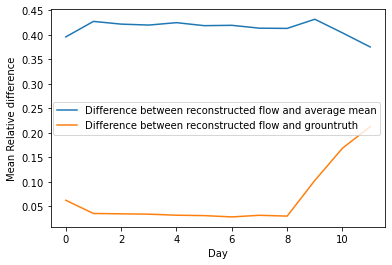

In [105]:
#Ecart entre les valeurs prédites au jour J et la valeur moyenne :
moy = np.mean(debit_gt[:,:,:],0)
moy2 = np.mean(moy,1)
print(moy2)
Ecart = np.zeros(debit_rec.shape)
for i in range(31):
    Ecart[:,i,:] =abs(debit_rec[:,i,:]-moy2[i])/moy2[i]
MoyEcart = np.mean(np.mean(Ecart,0),0)
print(MoyEcart)
plt.plot(MoyEcart)
plt.plot(M2)
plt.xlabel('Day')
plt.ylabel('Mean Relative difference')
plt.legend(['Difference between reconstructed flow and average mean', 'Difference between reconstructed flow and grountruth'])

50.3


NameError: name 'debit_rec_noKL' is not defined

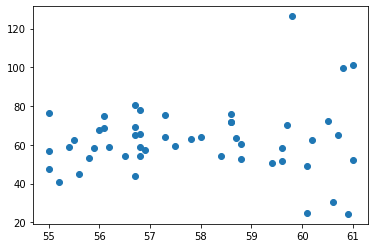

In [83]:
#qqplot extreme pour une station donnée en un jour de prévision donnée
station = 27
Day = 10
index_sort_gt = np.argsort(debit_gt[:,station,Day])
print(debit_gt[index_sort_gt[600],station,Day])
plt.scatter(debit_gt[index_sort_gt[650:700],station,Day],debit_rec[index_sort_gt[650:700],station,Day])
plt.scatter(debit_gt[index_sort_gt[650:700],station,Day],debit_rec_noKL[index_sort_gt[650:700],station,Day],color = 'red')
plt.plot(debit_gt[index_sort_gt[650:700],station,Day],debit_gt[index_sort_gt[650:700],station,Day])
plt.xlabel('True flow')
plt.ylabel('Reconstructed flow')
plt.figure()
plt.scatter(debit_gt[index_sort_gt,station,Day],debit_rec[index_sort_gt,station,Day])
plt.plot(debit_gt[index_sort_gt,station,Day],debit_gt[index_sort_gt,station,Day])
plt.figure()
#plt.scatter(debit_gt[index_sort_gt,station,Day],debit_rec_noKL[index_sort_gt,station,Day])
plt.plot(debit_gt[index_sort_gt,station,Day],debit_gt[index_sort_gt,station,Day])

31.5
[ 19  20  21  22  25  26  27  28  29  30  31  32  33  34  35  36  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  57  58  62  65  66  67
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  96  97  98  99 100 101 103 104 107 108 109 110 111 114 118 119 138
 139 140 144 145 146 148 149 150 167 168 171 172 173 174 175 176 177 178
 179 208 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259
 260 261 262 263 264 265 266 267 268 269 270 285 286 287 288 289 290 291
 292 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312
 313 314 315 316 317 318 319 320 321 322 323 324 331 333 341 342 343 344
 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362
 363 364 365 366 367 368 369 370 371 373 374 375 376 377 378 379 447 448
 449 450 456 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472
 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490
 491 492 493 494 495 496 497 498 499 500 501 5

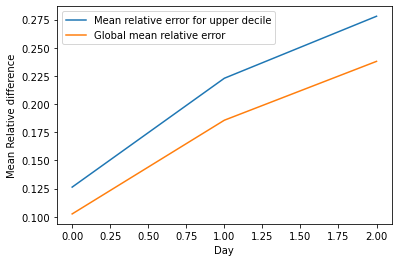

In [106]:
station=24
Day=9
debtrue = debit_gt[:,station,Day]
debtrue.sort()
seuil = debtrue[477]
print(seuil)
ind= np.where(debit_gt[:,station,Day]>seuil)
print(ind[0])
print(np.mean(abs(debit_gt[ind[0],station,Day]-debit_rec[ind[0],station,Day])/debit_gt[ind[0],station,Day]))
print(np.mean(abs(debit_gt[:,station,Day]-debit_rec[:,station,Day])/debit_gt[:,station,Day]))
print(np.mean(abs(debit_gt[ind[0],station,Day]-debit_rec[ind[0],station,Day])))
print(np.mean(abs(debit_gt[:,station,Day]-debit_rec[:,station,Day])))
print(np.mean(debit_gt[:,station]))
MRE_extreme = []
MRE=[]
for i in range(9,12):
    MRE.append(np.mean(abs(debit_gt[:,station,i]-debit_rec[:,station,i])/debit_gt[:,station,i]))
    debtrue = debit_gt[:,station,i]
    debtrue.sort()
    print(debit_gt[:50,station,i])
    seuil = debtrue[477]
    ind = np.where(debit_gt[:,station,i]>seuil)
    MRE_extreme.append(np.mean(abs(debit_gt[ind[0],station,i]-debit_rec[ind[0],station,i])/debit_gt[ind[0],station,i]))
    
    
print(MRE_extreme)
print(MRE)

plt.figure()
plt.plot(MRE_extreme)
plt.plot(MRE)
plt.xlabel('Day')
plt.ylabel('Mean Relative difference')
plt.legend(['Mean relative error for upper decile', 'Global mean relative error'])


### Comparaisons entre prévisions et persistance pour le jour 1

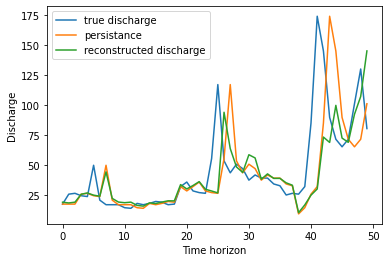

In [113]:
Day=10

debit_rec_true=debit_rec[:,:,Day]
debit_persistant = debit_gt[:,:,Day-2]
#debit_persistant = debit_rec[:,:,Day-1]
station = 25
# Comparaison GT et rec pour un élément donné du test
plt.plot(debit_gt[0:50,station,Day])
plt.plot(debit_persistant[0:50,station])
plt.plot(debit_rec_true[0:50,station])
plt.xlabel('Time horizon')
plt.ylabel('Discharge')
plt.legend(['true discharge', 'persistance','reconstructed discharge'])


In [108]:
#Erreur relative par station
D=abs(debit_gt[:,:,Day]-debit_rec_true[:,:])/debit_gt[:,:,Day]
print(D.shape)
# Erreur relative moyenne en fonction du jour et de la station
M = np.mean(D,0)
print(M.shape)
print(M[:])
#Erreur relative moyenne en fonction du jour
M2 =np.mean(M,0)
print(M2)

#Avec persistance
#Erreur relative en fonction du jour par station
D=abs(debit_gt[:,:,Day]-debit_persistant[:,:])/debit_gt[:,:,Day]
print(D.shape)
# Erreur relative moyenne en fonction du jour et de la station
M = np.mean(D,0)
print(M[:])
#Erreur relative moyenne en fonction du jour
M2 =np.mean(M,0)
print(M2)


(874, 31)
(31,)
[0.0647709169430868 0.049991404945245406 0.05769805034966517
 0.07716666228750944 0.06847444634375736 0.06667545398213579
 0.07475746156696117 0.08488901083201733 0.09036797110613883
 0.09605254008362313 0.16364131294923115 0.16989810616299977
 0.07387402706668907 0.06373553283919778 0.07485508860159819
 0.14068508625997558 0.1144877635780741 0.11652667733146815
 0.13634616650964737 0.09085353867674255 0.10728527360611256
 0.164883058477837 0.07783033136194972 0.10260514529192633
 0.1025248872976047 0.12211583533629058 0.13978933941277447
 0.13630784534655868 0.14539119720438343 0.10452039131456235
 0.10520656356129514]
0.10271635763313096
(874, 31)
[0.06466677194038796 0.06394539968172927 0.07260393756008171
 0.08481857502708 0.07818124529413022 0.07839678202515715
 0.08424681281622003 0.09442421035317297 0.09793793812848976
 0.10564122882296102 0.1650800871687169 0.15161901488495214
 0.07583928112960249 0.07168147905384804 0.08058587692626018
 0.14676710898135242 0.11

In [109]:
# Variance 
D_rec=(debit_gt[:,:,Day]-debit_rec_true[:,:])**2
#Variance par station
M_rec = np.mean(D_rec,0)
print(M_rec)


D_persistant = (debit_gt[:,:,Day]-debit_persistant[:,:])**2
#Variance par station
M_persistant = np.mean(D_persistant,0)
print(M_persistant)

V_exp = M_rec/M_persistant
print("Variance expliquée")
print(1-V_exp)
print(np.where(V_exp<0.5))
print(1-np.mean(V_exp))


[28587.34390715  2733.10520288  2182.81098228  3363.15750075
  1727.21483292  1454.56095653  1798.3848859    994.60426267
   957.99367723   603.81158861   425.47247574    83.03766063
 13856.86823115   320.4254665    359.1813283    353.9175307
   179.97794728   108.54928552    90.62522276   615.11917192
   333.32812995   357.41121893    76.48301088    78.35734897
   115.96744895   168.94384271   158.73571749   262.43028343
   250.42782921  4008.02485329  3349.6630288 ]
[31362.83180778  5756.73798627  4243.97482838  4818.39702517
  2884.66475973  2565.9187643   2733.62929062  1314.31124714
  1199.12827231   805.623627     474.89496568    91.49858295
 17169.25400458   490.88786041   508.71718535   473.29016018
   217.29240275   121.85018993    97.67208787   766.62162471
   388.1026659    376.18332952   140.30797483   135.95140767
   317.09203661   336.41994554   181.6150397    258.72924783
   260.3445762   5594.60718535  4398.05418764]
Variance expliquée
[0.08849608726791547 0.52523369842

#### Récapitulatif des résultats pour différentes configurations


<table>
<caption style="caption-side:bottom">Tableau des résultats</caption>
<tr>
<th>Configuration</th>
<th>Batch</th>
<th>Epoch</th>
<th>KL</th>
<th>MRE Day 1</th>
<th>MRE Day 2</th>
<th>MRE Day 3</th>
<th>Variance expliquée Day 1</th>
<th>Variance expliquée Day 2</th>
<th>Variance expliquée Day 3</th>
</tr>
<tr>
<td>1</td>
<td>96</td>
<td>31</td>    
<td>YES</td>
<td>10,3%</td>
<td>16,9%</td>
<td>21,1%</td>
<td>28,8%</td>
<td>23,5%</td>
<td>22,6%</td>
</tr>
<tr>
<td>2</td>
<td>96</td>
<td>33</td> 
<td>NO</td>
<td>12,0%</td>
<td>18,0%</td>
<td>22,2%</td>
<td>25,4%</td>
<td>23,9%</td>
<td>22,8%</td>
</tr>
</table>

# Critère KL pour les extrêmes

In [40]:
X1= t.rvs(2.5, size=10000)
print(max(X1))
Y1=t.rvs(1.5, size=10000)
print(max(Y1))
print(np.sum(X1>20))
print(np.sum(Y1>20))

31.06474491349434
277.9718856864301
3
54


(array([   1,    3,    4, ..., 9988, 9995, 9999]),)
-0.5861276874062169


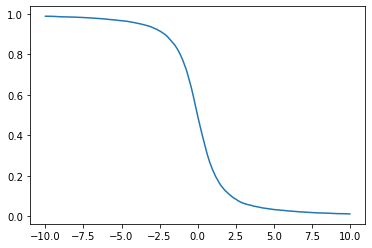

In [41]:
from statsmodels.distributions.empirical_distribution import ECDF
l=len(Y1)
ecdf = ECDF(Y1)
def G_bar(x):
    return(1-ecdf(x))
print(np.where(Y1>1))

def L_hat_opti(u,Y,X):
    Ind = np.where(X>u)
    ecdf = ECDF(Y)
    l=len(Y)
    def G_thilde_opti(x):
        return(l/(l+1)*(1-ecdf(x))+1/(l+1))
    G_u= G_thilde_opti(u)
    A = np.log(G_thilde_opti(X[Ind])/G_u)
    res=np.sum(A)/len(Ind[0])+1
    return(res)


print(L_hat_opti(3,X1,Y1))    
x= np.linspace(-10,10,1000)
l=len(Y1)
plt.plot(x,l*G_bar(x)/(l+1)+1/(l+1))


In [42]:
# Critère non-paramétrique de KL pour les extrêmes


def G_thilde(u,Y):
    l=len(Y)
    return (1-np.sum(Y<=u)/(l+1))

def L_hat(u,Y,X):
    Nn = np.sum(X>u)
    res=0
    count=0
    for k in X:
        res+=(1/Nn)*np.log(G_thilde(max(k,u),Y)/G_thilde(u,Y)) 
        count+=1
    return(1+res)
                         

def K_hat(u,Y,X):
    return(-L_hat(u,Y,X)-L_hat(u,X,Y))


print(G_thilde(3,Y1))
print(K_hat(3,Y1,Y1))
#print(L_hat(3,X1,Y1))
print(K_hat(3,X1,Y1))


#Accélération du calcul de KL


def L_hat_opti(u,Y,X):
    Ind = np.where(X>u)
    if len(Ind[0])==0 :
        return(1)
    else : 
        ecdf = ECDF(Y)
        l=len(Y)
        def G_thilde_opti(x):
            return(l/(l+1)*(1-ecdf(x))+1/(l+1))
        G_u= G_thilde_opti(u)
        M= X[Ind]
        B= G_thilde_opti(M)/G_u
        A = np.log(B)
        res=np.sum(A)/len(Ind[0])+1 
        return(res)


def K_hat(u,Y,X):
    return(-L_hat_opti(u,Y,X)-L_hat_opti(u,X,Y))


def K_hat_tensor(seuil,X,Y):
    n=X.shape[0]
    res=0
    for i in range(n):
        resi=K_hat(seuil[i],X[i,:],Y[i,:])
        res+=resi
    return(res)

print(K_hat(3,X1,Y1))

0.06469353064693528
-0.009768546377812992
0.19388859240499945
0.1938885924050252


In [69]:
print(type(debit_gt[:]))
Day=10
seuil_10 = [2220,  1020. ,  764.,   744. ,  577. ,  535.,   511.,   329.,   279. ,  218.,
   92.3 ,  45.,  1240.,   257. ,  250.,   116. ,   81.5,   46.7,   35.3,  179.,
  130.,   123.,    96.5,   78.6 ,  69.,    62.1,   47.6 ,  81.8,   74.4 , 449.,
  427. ]
print(seuil_10)
gt = debit_gt[:,:,Day]
print(gt.shape)
print(debit_rec_true.shape)
debit_rec_true_noKL = debit_rec_noKL[:,:,Day]
L_rec=[]
L_pers=[]
for k in range(31):
    L_rec.append(K_hat(seuil_10[k],gt[:,k],debit_rec_true[:,k])-K_hat(seuil_10[k],gt[:,k],gt[:,k]))#min(K_hat(seuil_10[k],gt[:,k],gt[:,k]),K_hat(seuil_10[k],debit_rec_true[:,k],debit_rec_true[:,k])))
    #print(K_hat(seuil_10[k],gt[:,k],debit_rec_true[:,k]))
    #print(K_hat(seuil_10[k],gt[:,k],gt[:,k]))
    #print(K_hat(seuil_10[k],debit_rec_true[:,k],debit_rec_true[:,k]))
    L_pers.append(K_hat(seuil_10[k],gt[:,k],debit_rec_true_noKL[:,k])-K_hat(seuil_10[k],gt[:,k],gt[:,k]))#-min(K_hat(seuil_10[k],gt[:,k],gt[:,k]),K_hat(seuil_10[k],debit_rec_true_noKL[:,k],debit_rec_true_noKL[:,k])))
print(L_rec)
print(L_pers)


<class 'numpy.ma.core.MaskedArray'>
[2220, 1020.0, 764.0, 744.0, 577.0, 535.0, 511.0, 329.0, 279.0, 218.0, 92.3, 45.0, 1240.0, 257.0, 250.0, 116.0, 81.5, 46.7, 35.3, 179.0, 130.0, 123.0, 96.5, 78.6, 69.0, 62.1, 47.6, 81.8, 74.4, 449.0, 427.0]
(874, 31)
(874, 31)
[-0.060867849654955175, -0.06005285810365868, -0.059677935374746194, -0.06647670342149814, -0.035626855406495905, -0.04873744140100622, -0.0539375789922516, -0.04739085357340922, -0.07249840237435567, -0.07619362377276817, -0.003629184789935458, -0.01842560698335971, -0.05427378818542539, -0.06199965953119324, -0.055496095590960026, -0.05864401428201227, -0.053861622803918374, -0.02817798941818095, -0.015160365163781941, -0.044877616610610405, -0.03329921401311564, -0.04138642107127699, -0.0570460586010334, -0.057396520420465724, -0.04708262725948198, -0.03770221285087516, 0.021321733050041036, -0.0014212903493028284, -0.026302189469190274, -0.03701884342442474, -0.0203032207829692]
[-0.04595964176174461, -0.05311806796120566, 

### Paramètre de forme pour chaque station

In [28]:
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages

base = importr('base')
utils = importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages('POT') #installing POT package

R[write to console]: Installing package into ‘/home/VM-Nicolas-Lafon/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/POT_1.1-7.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1028906 bytes (1004 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f8e64a127c0> [RTYPES.NILSXP]

In [29]:
from thresholdmodeling import thresh_modeling as t#importing package
    
    

<table>
<caption style="caption-side:bottom">Paramètre de forme par station, seuil à 10%</caption>
<tr>
<th>Station</th>
<th>1</th>
<th>2</th>
<th>3</th>
<th>4</th>
<th>5</th>
<th>6</th>
<th>7</th>
<th>8</th>
<th>9</th>
<th>10</th>
<th>11</th>
<th>12</th>
<th>13</th>
<th>14</th>
<th>15</th>
<th>16</th>
<th>17</th>
<th>18</th>
<th>19</th>
<th>20</th>
<th>21</th>
<th>22</th>
<th>23</th>
<th>24</th>
<th>25</th>
<th>26</th>
<th>27</th>
<th>28</th>
<th>29</th>
<th>30</th>
<th>31</th>
</tr>
<tr>
<th>Shape</th>
<th>0.061</th>
<th>0.052</th>
<th>0.083</th>
<th>0.073</th>
<th>0.062</th>
<th>0.092</th>
<th>0.086</th>
<th>0.055</th>
<th>0.052</th>
<th>0.050</th>
<th>0.20</th>
<th>0.15</th>
<th>0.15</th>
<th>0.18</th>
<th>0.22</th>
<th>0.21</th>
<th>0.24</th>
<th>0.28</th>
<th>0.29</th>
<th>0.34</th>
<th>0.23</th>
<th>0.21</th>
<th>0.14</th>
<th>0.14</th>
<th>0.25</th>
<th>0.26</th>
<th>0.28</th>
<th>0.22</th>
<th>0.24</th>
<th>0.18</th>
<th>0.18</th>
</tr>
<tr>
<th>Standard Error</th>
<th>0.035</th>
<th>0.027</th>
<th>0.028</th>
<th>0.027</th>
<th>0.026</th>
<th>0.027</th>
<th>0.026</th>
<th>0.027</th>
<th>0.026</th>
<th>0.026</th>
<th>0.028</th>
<th>0.024</th>
<th>0.027</th>
<th>0.027</th>
<th>0.027</th>
<th>0.028</th>
<th>0.030</th>
<th>0.032</th>
<th>0.030</th>
<th>0.032</th>
<th>0.028</th>
<th>0.028</th>
<th>0.027</th>
<th>0.026</th>
<th>0.032</th>
<th>0.031</th>
<th>0.031</th>
<th>0.028</th>
<th>0.028</th>
<th>0.027</th>
<th>0.027</th>
</tr>
</table>

'nan'


## Résultats pour la paramétrisation GPD

### Etude de la reconstrucion

#### Chargement des données

In [21]:
debit_gt = ncfile['debit_gt']
debit_obs = ncfile['debit_obs']
debit_rec = ncfile['debit_rec']
mu = ncfile['Cov_rec']
sig = [0.9543, 1.5295, 1.4263, 0.6052, 1.2841, 1.7961, 1.3901, 1.5834, 0.8622,
        1.0710, 1.2992, 1.0022, 1.7475, 1.5874, 1.9400, 0.8894, 1.0312, 1.0667,
        0.8751, 1.6873, 0.9720, 1.2567, 1.7736, 1.7745, 0.3143, 1.1844, 1.1953,
        1.6283, 1.1531, 1.4303, 1.5385]
xi = [5.3415e-01, 1.8824e-02, 3.3814e-05, 2.7188e-01, 5.6676e-01, 2.9808e-01,
        3.1386e-01, 1.8921e-01, 5.8023e-01, 7.2833e-01, 2.6617e-02, 4.9925e-01,
        1.5194e-03, 5.5939e-01, 3.6711e-04, 2.8322e-01, 2.0990e-01, 1.1705e-01,
        7.4237e-01, 1.8645e-02, 4.1478e-01, 7.1758e-01, 5.9190e-01, 3.9100e-02,
        1.1820e+00, 1.4506e-01, 5.2542e-01, 2.8226e-02, 7.1482e-02, 1.0162e-01,
        4.4780e-02]
#debit_rec_noKL = ncfile_noKL['debit_rec']

print(meanTr)
print(stdTrtrue)

[[1408.89511683]
 [ 636.69982421]
 [ 459.37888525]
 [ 447.58122296]
 [ 355.48190841]
 [ 333.49443423]
 [ 313.82963747]
 [ 194.59088886]
 [ 164.1200726 ]
 [ 123.88170409]
 [  45.94225616]
 [  20.98234251]
 [ 732.45846793]
 [ 171.22450546]
 [ 159.76592053]
 [  62.21748479]
 [  47.22112274]
 [  27.07170021]
 [  19.77740626]
 [ 112.3562124 ]
 [  78.96774858]
 [  69.78310911]
 [  49.65254831]
 [  37.71500896]
 [  37.27055053]
 [  33.91270081]
 [  25.69208123]
 [  41.1601416 ]
 [  36.92663292]
 [ 251.11069549]
 [ 236.41687593]]
[[615.29022273]
 [302.12914092]
 [242.07383293]
 [235.9017023 ]
 [182.1544381 ]
 [167.71036231]
 [162.09765076]
 [112.39458861]
 [ 93.44056986]
 [ 75.47962957]
 [ 39.58097984]
 [ 18.98766957]
 [388.90588264]
 [ 68.7610357 ]
 [ 68.07842772]
 [ 49.26943174]
 [ 30.83505757]
 [ 22.39660877]
 [ 20.16504399]
 [ 62.16576929]
 [ 48.9457699 ]
 [ 46.38744878]
 [ 40.66105836]
 [ 35.5884955 ]
 [ 30.04437364]
 [ 27.330319  ]
 [ 20.38169141]
 [ 33.38784294]
 [ 31.48578322]
 [162.29

#### Visualisation pour une fenêtre

(874, 31, 12)


<Figure size 432x288 with 0 Axes>

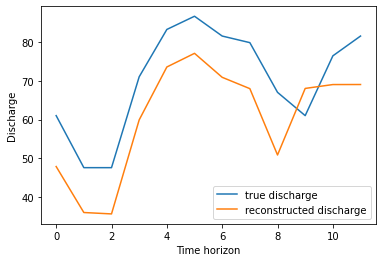

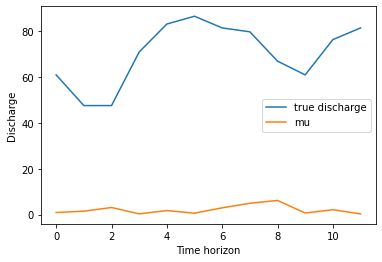

<Figure size 432x288 with 0 Axes>

In [22]:
station = 20

print(debit_gt[:].shape)

# Comparaison GT et rec pour un élément donné du test
plt.plot(debit_gt[30,station,:])
plt.plot(debit_rec[30,station,:])
plt.xlabel('Time horizon')
plt.ylabel('Discharge')
plt.legend(['true discharge', 'reconstructed discharge'])
plt.figure()
plt.plot(debit_gt[30,station,:])
plt.plot(meanTr[station]+mu[30,station,:]*stdTrtrue[station])
plt.xlabel('Time horizon')
plt.ylabel('Discharge')
plt.legend(['true discharge', 'mu'])
plt.figure()

#### Visualisation de la reconstruction pour une station donnée

(874, 31, 12)


<Figure size 432x288 with 0 Axes>

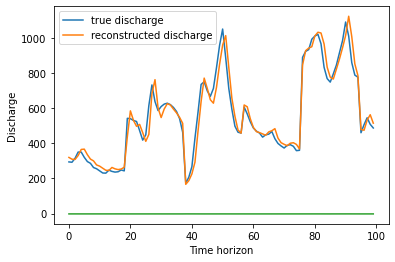

<Figure size 432x288 with 0 Axes>

In [23]:
station = 3
Day = 9
print(debit_gt[:].shape)

# Comparaison GT et rec pour un élément donné du test
plt.plot(debit_gt[0:100,station,Day])
plt.plot(debit_rec[0:100,station,Day])
plt.plot(mu[0:100,station,Day])
plt.xlabel('Time horizon')
plt.ylabel('Discharge')
plt.legend(['true discharge', 'reconstructed discharge'])
plt.figure()


#### Comparaison avec la persistance pour une station donnée

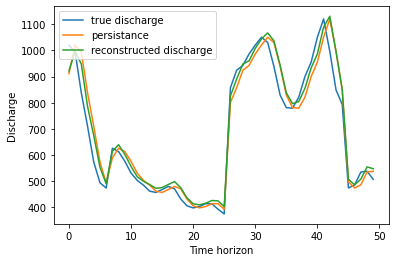

In [24]:
debit_rec_true=debit_rec[:,:,Day]
debit_persistant = debit_gt[:,:,Day-1]
#debit_persistant = debit_rec[:,:,Day-1]
station = 2
# Comparaison GT et rec pour un élément donné du test
plt.plot(debit_gt[50:100,station,Day])
plt.plot(debit_persistant[50:100,station])
plt.plot(debit_rec_true[50:100,station])
plt.xlabel('Time horizon')
plt.ylabel('Discharge')
plt.legend(['true discharge', 'persistance','reconstructed discharge'])


#### Erreur relative par station comparée à la persistance

In [25]:
#Erreur relative par station
D=abs(debit_gt[:,:,Day]-debit_rec_true[:,:])/debit_gt[:,:,Day]
print(D.shape)
# Erreur relative moyenne en fonction du jour et de la station
M = np.mean(D,0)
print(M.shape)
print(M[:])
#Erreur relative moyenne en fonction du jour
M2 =np.mean(M,0)
print(M2)

#Avec persistance
#Erreur relative en fonction du jour par station
D=abs(debit_gt[:,:,Day]-debit_persistant[:,:])/debit_gt[:,:,Day]
print(D.shape)
# Erreur relative moyenne en fonction du jour et de la station
M = np.mean(D,0)
print(M[:])
#Erreur relative moyenne en fonction du jour
M2 =np.mean(M,0)
print(M2)

(874, 31)
(31,)
[0.06983839779795674 0.06597338644610196 0.07922060015434097
 0.08847340999907326 0.08094596125992527 0.0756258411943592
 0.07734041202810375 0.0850768913640361 0.08897060987206888
 0.09653580559913201 0.1759260625400502 0.152973825941643
 0.07081645172520228 0.06635126043234997 0.07641372728242679
 0.1422943162565739 0.1166862657089808 0.12156511727348687
 0.11018352075622219 0.09285648714624933 0.10205920530353067
 0.1642505334155458 0.07580015914269234 0.1068504471172377
 0.12178968767987111 0.13656227623038444 0.13705722078428356
 0.1433444975077233 0.15836953939454138 0.12152405289058399
 0.11441633008773026]
0.10697071936556155
(874, 31)
[0.06466677194038796 0.06394539968172927 0.07260393756008171
 0.08481857502708 0.07818124529413022 0.07839678202515715
 0.08424681281622003 0.09442421035317297 0.09793793812848976
 0.10564122882296102 0.1650800871687169 0.15161901488495214
 0.07583928112960249 0.07168147905384804 0.08058587692626018
 0.14676710898135242 0.11895083

#### Variance expliquée

In [26]:
# Variance 
D_rec=(debit_gt[:,:,Day]-debit_rec_true[:,:])**2
#Variance par station
M_rec = np.mean(D_rec,0)
print(M_rec)


D_persistant = (debit_gt[:,:,Day]-debit_persistant[:,:])**2
#Variance par station
M_persistant = np.mean(D_persistant,0)
print(M_persistant)

V_exp = M_rec/M_persistant
print("Variance expliquée")
print(1-V_exp)
print(np.where(V_exp<0.5))
print(1-np.mean(V_exp))

[31654.60431556  4643.57386     3341.7943809   4105.00056111
  2313.67577339  1909.80772721  2208.86258949  1093.68794234
  1054.98118361   687.22126873   414.06862717    80.38453139
 16744.42164759   367.56638445   404.60501756   394.34567794
   190.96167426   110.28486307    90.94517266   705.98886205
   346.30841774   353.0116301    112.19395853   125.28581929
   276.49561234   285.98903605   168.42285309   236.93627532
   228.30426339  5025.94568465  3769.70775315]
[31362.83180778  5756.73798627  4243.97482838  4818.39702517
  2884.66475973  2565.9187643   2733.62929062  1314.31124714
  1199.12827231   805.623627     474.89496568    91.49858295
 17169.25400458   490.88786041   508.71718535   473.29016018
   217.29240275   121.85018993    97.67208787   766.62162471
   388.1026659    376.18332952   140.30797483   135.95140767
   317.09203661   336.41994554   181.6150397    258.72924783
   260.3445762   5594.60718535  4398.05418764]
Variance expliquée
[-0.00930313020084772 0.193367168

### Etude du paramètre mu

#### Visualisation de mu

(874, 31, 12)
800
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176

<Figure size 432x288 with 0 Axes>

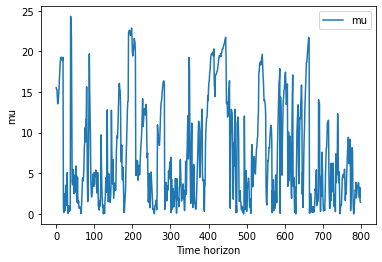

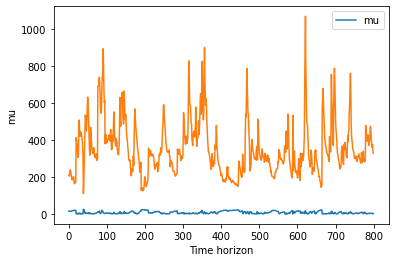

<Figure size 432x288 with 0 Axes>

In [27]:
station = 5
Day = 9
print(mu.shape)
# Comparaison GT et rec pour un élément donné du test

plt.plot(meanTr[station]+mu[0:800,station,Day]*stdTrtrue[station])
plt.xlabel('Time horizon')
plt.ylabel('mu')
plt.legend(['mu'])
plt.figure()
print(np.sum((meanTr[station]+mu[0:800,station,Day]*stdTrtrue[station]>0)))

Indpos = np.where((meanTr[station]+mu[0:800,station,Day]*stdTrtrue[station]>0))
print(Indpos)
plt.plot(meanTr[station]+mu[Indpos[0],station,Day]*stdTrtrue[station])
plt.plot(debit_gt[Indpos[0],station,Day])
plt.xlabel('Time horizon')
plt.ylabel('mu')
plt.legend(['mu'])
plt.figure()

#### Rapport mu sur l'observation

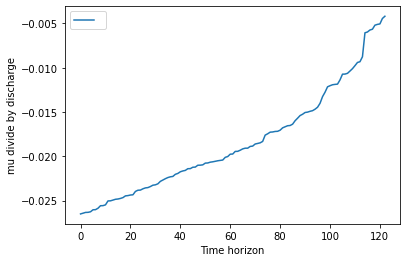

In [30]:

station = 17
Day = 9

rapport = mu[:,station,Day]/debit_gt[:,station,Day]
index = np.argsort(rapport)
rapport[index[0:10]]
plt.plot(rapport[index[750:-1]])
plt.xlabel('Time horizon')
plt.ylabel('mu divide by discharge')
plt.legend([''])

#### Variations de mu et du débit

<Figure size 432x288 with 0 Axes>

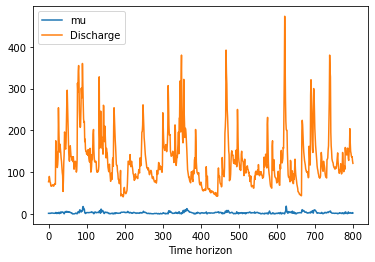

<Figure size 432x288 with 0 Axes>

In [41]:
station = 9
Day = 9

# Comparaison GT et rec pour un élément donné du test

plt.plot(meanTr[station]+mu[0:800,station,Day]*stdTrtrue[station])
plt.plot(debit_gt[0:800,station,Day])
plt.xlabel('Time horizon')
plt.ylabel('')
plt.legend(['mu','Discharge'])
plt.figure()

### Etude de sigma

#### Visualisation de sigma

<Figure size 432x288 with 0 Axes>

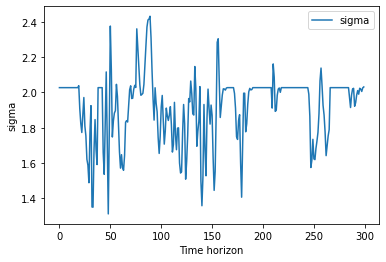

<Figure size 432x288 with 0 Axes>

In [60]:
station = 2
Day = 9

# Comparaison GT et rec pour un élément donné du test

plt.plot(sig[0:300,station,Day])
plt.xlabel('Time horizon')
plt.ylabel('sigma')
plt.legend(['sigma'])
plt.figure()

#### Lien entre sigma et mu

Text(0, 0.5, 'sigma')

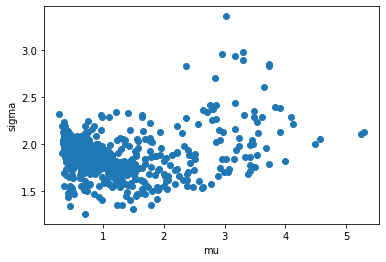

In [63]:
station = 2
Day = 9

plt.scatter(mu[:,station,Day],sig[:,station,Day])
plt.xlabel('mu')
plt.ylabel('sigma')

#### Lien entre sigma et les débits réels

Text(0, 0.5, 'sigma')

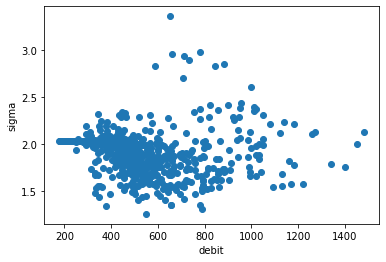

In [64]:
station = 2
Day = 9

plt.scatter(debit_gt[:,station,Day],sig[:,station,Day])
plt.xlabel('debit')
plt.ylabel('sigma')

### Etude de xi

#### Visualisation de xi

<Figure size 432x288 with 0 Axes>

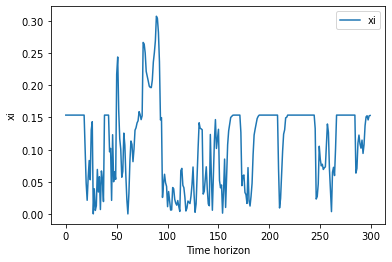

<Figure size 432x288 with 0 Axes>

In [65]:
station = 2
Day = 9

# Comparaison GT et rec pour un élément donné du test

plt.plot(xi[0:300,station,Day])
plt.xlabel('Time horizon')
plt.ylabel('xi')
plt.legend(['xi'])
plt.figure()

#### Lien entre xi et mu

Text(0, 0.5, 'xi')

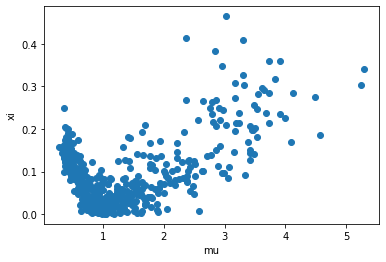

In [66]:
station = 2
Day = 9

plt.scatter(mu[:,station,Day],xi[:,station,Day])
plt.xlabel('mu')
plt.ylabel('xi')

#### Lien entre xi et le débit

Text(0, 0.5, 'xi')

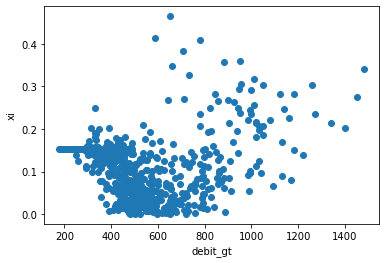

In [67]:
station = 2
Day = 9

plt.scatter(debit_gt[:,station,Day],xi[:,station,Day])
plt.xlabel('debit_gt')
plt.ylabel('xi')

#### Lien entre xi et sigma

Text(0, 0.5, 'xi')

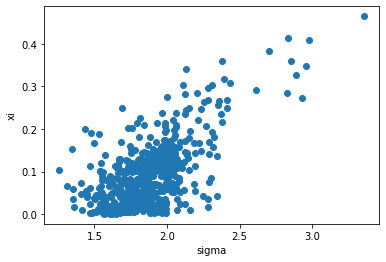

In [74]:
station = 2
Day = 9

plt.scatter(sig[:,station,Day],xi[:,station,Day])
plt.xlabel('sigma')
plt.ylabel('xi')